<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/RNN_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

In [2]:
data = []
with open("/content/DeteksiSarkasme.json", "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
texts = df['headline'].values
labels = df['is_sarcastic'].values

def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower().split()

texts = [clean_text(t) for t in texts]

word_counts = Counter(word for sentence in texts for word in sentence)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(sentence):
    return [vocab.get(word, vocab['<UNK>']) for word in sentence]

encoded = [torch.tensor(encode(s)) for s in texts]
padded = pad_sequence(encoded, batch_first=True, padding_value=0)
labels = torch.tensor(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [3]:
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_data = SarcasmDataset(X_train, y_train)
test_data = SarcasmDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return self.sigmoid(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(vocab_size=len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
train_losses = []
test_accuracies = []

for epoch in range(10):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(texts).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts).squeeze()
            preds = (outputs > 0.5).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Test Accuracy: {acc:.4f}")


Epoch 1, Loss: 229.1217, Test Accuracy: 0.5608
Epoch 2, Loss: 229.0501, Test Accuracy: 0.5608
Epoch 3, Loss: 229.0764, Test Accuracy: 0.5608
Epoch 4, Loss: 229.0465, Test Accuracy: 0.5608
Epoch 5, Loss: 229.0443, Test Accuracy: 0.5608
Epoch 6, Loss: 229.0152, Test Accuracy: 0.5608
Epoch 7, Loss: 229.0267, Test Accuracy: 0.5608
Epoch 8, Loss: 226.1824, Test Accuracy: 0.6484
Epoch 9, Loss: 161.6092, Test Accuracy: 0.8102
Epoch 10, Loss: 98.8182, Test Accuracy: 0.8276


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()
all_probs, all_preds, all_labels = [], [], []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts).squeeze()
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).long().cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

print("=== Evaluation Metrics ===")
print(f"Akurasi  : {accuracy:.4f}")
print(f"Presisi  : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


=== Evaluation Metrics ===
Akurasi  : 0.8276
Presisi  : 0.7909
Recall   : 0.8257
F1-Score : 0.8079
AUC      : 0.9081


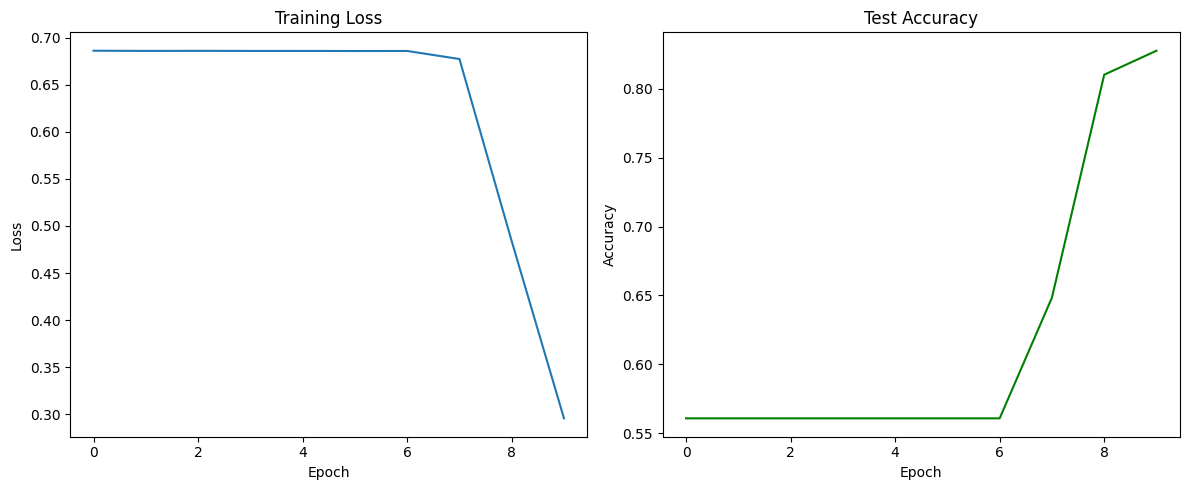

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy", color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


#Tensorflow Hyperparameter Tunning

In [10]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [11]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [12]:
data = []
with open("/content/DeteksiSarkasme.json", "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

texts = df['headline'].astype(str).values
labels = df['is_sarcastic'].values

def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower()

texts = [clean_text(t) for t in texts]

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=40)

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [15]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=10000,
        output_dim=hp.Choice('embedding_dim', [32, 64, 128]),
        input_length=40
    ))
    model.add(GRU(
        units=hp.Int('gru_units', min_value=64, max_value=256, step=32),
        return_sequences=False
    ))
    model.add(Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])

    # Compile the model first with the chosen optimizer
    model.compile(
        optimizer=hp_optimizer,  # Pass the optimizer name here
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Now set the learning rate
    model.optimizer.learning_rate = hp_learning_rate

    return model

In [16]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='sarcasm_rnn'
)

tuner.search(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2)]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"GRU Units      : {best_hps.get('gru_units')}")
print(f"Embedding Dim  : {best_hps.get('embedding_dim')}")
print(f"Optimizer      : {best_hps.get('optimizer')}")
print(f"Learning Rate  : {best_hps.get('learning_rate')}")


Trial 5 Complete [00h 04m 36s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.7987833619117737
Total elapsed time: 00h 18m 44s
Best Hyperparameters:
GRU Units      : 96
Embedding Dim  : 128
Optimizer      : adam
Learning Rate  : 0.01


In [17]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.5512 - loss: 0.6911 - val_accuracy: 0.5538 - val_loss: 0.6876
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.5539 - loss: 0.6898 - val_accuracy: 0.5281 - val_loss: 0.6949
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.5685 - loss: 0.6826 - val_accuracy: 0.5824 - val_loss: 0.6781
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 111ms/step - accuracy: 0.6248 - loss: 0.6434 - val_accuracy: 0.5800 - val_loss: 0.6914
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.7180 - loss: 0.5536 - val_accuracy: 0.6245 - val_loss: 0.6728
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.7815 - loss: 0.4716 - val_accuracy: 0.6306 - val_loss: 0.7048
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - accuracy: 0.8213 - loss: 0.4067 - val_accuracy: 0.6425 - val_loss: 0.7082


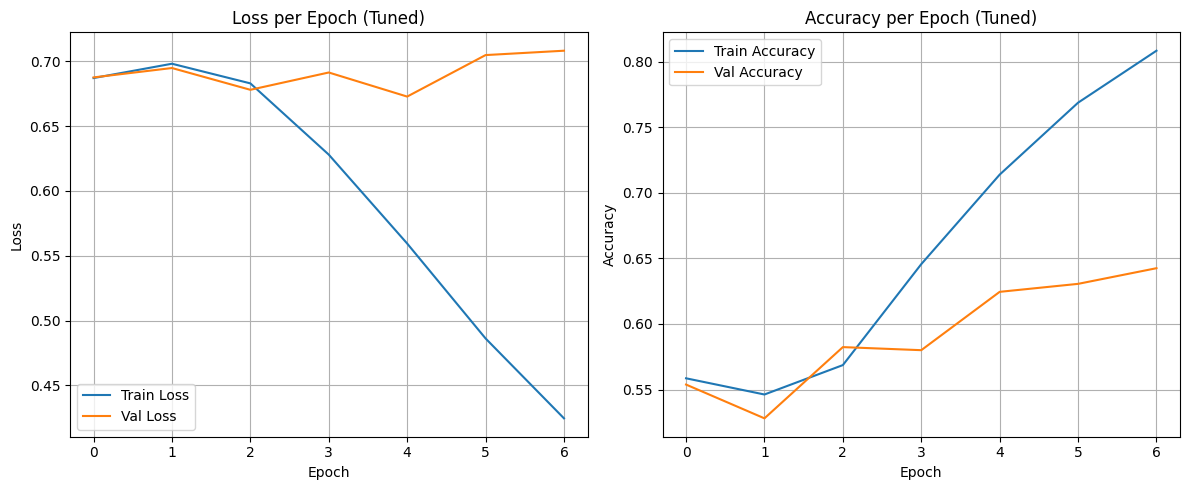

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss per Epoch (Tuned)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy per Epoch (Tuned)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
=== Final Evaluation with Best Hyperparameters ===
Akurasi  : 0.6260
Presisi  : 0.5815
Recall   : 0.5294
F1-Score : 0.5542
AUC      : 0.6687


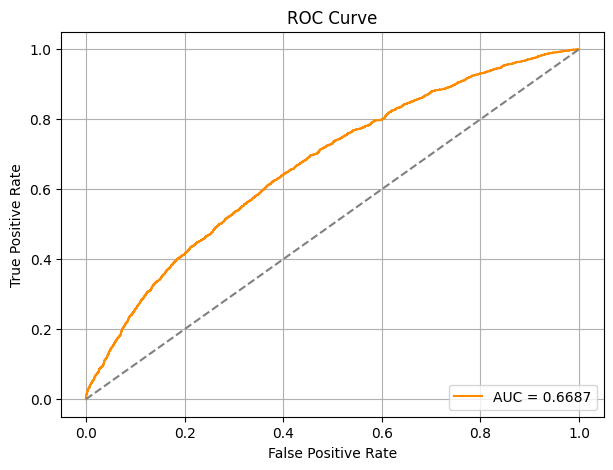

In [19]:
# Prediksi
y_probs = best_model.predict(X_test).flatten()
y_preds = (y_probs > 0.5).astype(int)

# Evaluasi metrik
acc = accuracy_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
auc = roc_auc_score(y_test, y_probs)

print("=== Final Evaluation with Best Hyperparameters ===")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Visualisasi ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
